<a href="https://colab.research.google.com/github/nelrob/movie-ranking-prediction/blob/main/Movie_Ranking_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Data

In [3]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.3/89.3 KB 3.8 MB/s eta 0:00:00


In [4]:
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
 
import numpy as np
import tensorflow as tf
 
from typing import Dict, Text
import pprint

# Data Pre-processing

In [5]:
# # ** Another way to split training and testing
# # ** Used later for KFold cross validation

# from sklearn.model_selection import train_test_split
# # Split the data into train and test sets
# train_ratings, test_ratings = train_test_split(ratings, test_size=0.2)

In [6]:
ratings, info = tfds.load("movielens/100k-ratings", with_info=True, split=tfds.Split.TRAIN)
# ratings, info = tfds.load("movielens/100k-ratings", with_info=True)
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"]
})


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-ratings/0.1.1.incompleteIJNW6U/movielens-train.tfrecord*...…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.1. Subsequent calls will reuse this data.


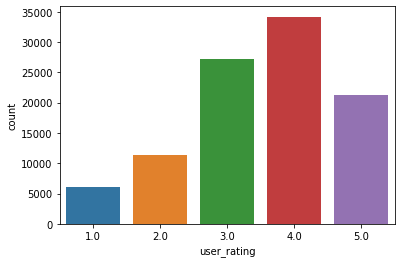

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the dataset to a Pandas DataFrame
df = tfds.as_dataframe(ratings, info)

# Visualize the data
sns.countplot(x='user_rating', data=df)
plt.show()

In [8]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

In [9]:
movie_titles = ratings.batch(1_000_000).map(lambda x: x["movie_title"])
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

In [10]:
class RankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.movie_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    # Compute predictions.
    self.ratings = tf.keras.Sequential([
      # Learn multiple dense layers.
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1)
  ])
    
  def call(self, inputs):

    user_id, movie_title = inputs

    user_embedding = self.user_embeddings(user_id)
    movie_embedding = self.movie_embeddings(movie_title)

    return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

In [11]:
RankingModel()((["42"], ["One Flew Over the Cuckoo's Nest (1975)"]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.03740937]], dtype=float32)>

In [12]:
# Loss model changed from MeanSquaredError
# Metrics model changed from RootMeanSquaredError
task = tfrs.tasks.Ranking(loss=tf.keras.losses.MeanAbsoluteError(),
                          metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

In [13]:
class MovielensModel(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      # Loss model changed from MeanSquaredError
      loss = tf.keras.losses.MeanAbsoluteError(),
      # Metrics model changed from RootMeanSquaredError
      metrics=[tf.keras.metrics.MeanAbsolutePercentageError()]
    )

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(
        (features["user_id"], features["movie_title"]))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    labels = features.pop("user_rating")
    
    rating_predictions = self(features)

    # The task computes the loss and the metrics.
    return self.task(labels=labels, predictions=rating_predictions)

In [14]:
# # ** KFold Cross validation

# from sklearn.model_selection import KFold


# kfold = KFold(n_splits=5, shuffle=True)
# for train_index, val_index in kfold.split(ratings_list):
#   model = MovielensModel()
#   model.compile(optimizer='adam')
#   model.fit(train[train_index], epochs=10, callbacks=[EarlyStopping], validation_data=train[val_index])
#   model.evaluate(test)

In [15]:
model = MovielensModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [16]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [17]:
history = model.fit(cached_train, epochs=3)

Epoch 1/3
10/10 [==============================] - 5s 73ms/step - mean_absolute_percentage_error: 58.0109 - loss: 1.7803 - regularization_loss: 0.0000e+00 - total_loss: 1.7803
Epoch 2/3
10/10 [==============================] - 0s 49ms/step - mean_absolute_percentage_error: 41.5879 - loss: 1.0297 - regularization_loss: 0.0000e+00 - total_loss: 1.0297
Epoch 3/3
10/10 [==============================] - 0s 48ms/step - mean_absolute_percentage_error: 41.3354 - loss: 0.9687 - regularization_loss: 0.0000e+00 - total_loss: 0.9687


In [18]:
model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 3s 25ms/step - mean_absolute_percentage_error: 39.3391 - loss: 0.9354 - regularization_loss: 0.0000e+00 - total_loss: 0.9354


{'mean_absolute_percentage_error': 39.339080810546875,
 'loss': 0.926116943359375,
 'regularization_loss': 0,
 'total_loss': 0.926116943359375}

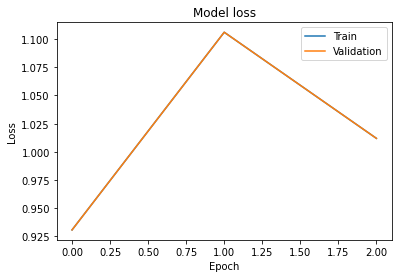

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['total_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [29]:
# test_ratings = {}
# test_movie_titles = ["M*A*S*H (1970)", "Dances with Wolves (1990)", "Speed (1994)"]
# for movie_title in test_movie_titles:
#   test_ratings[movie_title] = model({
#       "user_id": np.array(["42"]),
#       "movie_title": np.array([movie_title])
#   })
import random
import pandas as pd

ratings_pred = {}
user_pred = 33
ifGenerate = input("Generate a list of movies to try? (Y/N): ")

movies = ratings.map(lambda x: x["movie_title"])
if (ifGenerate == "y"):
  # extract movie titles from the dataset
  movies = set([str(x.numpy()) for x in movies])


  # Generate a list of random movie titles
  random_movies = random.sample(movies, 5)
  # Print the random movies
  print("Here are some random movies for you to try:")
  for movie in random_movies:
    print("- " + movie)



movie_title_pred = input("Enter the movie to predict ratings for: ")
ratings_pred = model({
      "user_id": np.array(["42"]),
      "movie_title": np.array([movie_title_pred])
  })
print("Ratings:")
for title, score in sorted(ratings_pred(), key=lambda x: x[1], reverse=True):
  print(f"{title}: {score}")

# print("Ratings:")
# for title, score in sorted(test_ratings.items(), key=lambda x: x[1], reverse=True):
#   print(f"{title}: {score}")

Generate a list of movies to try? (Y/N): y
Here are some random movies for you to try:
- b'T-Men (1947)'
- b'Lassie (1994)'
- b'Rebel Without a Cause (1955)'
- b'Ayn Rand: A Sense of Life (1997)'
- b'Duck Soup (1933)'
Enter the movie to predict ratings for: Duck Soup (1933)
Ratings:


TypeError: ignored